In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
user = pd.read_csv('../Data/whyout_data/user.csv') # (31177,3)
drop_user_place_idx = pd.read_csv('../Data/whyout_data/drop_user_place_idx.csv') # (22420,4)
drop_user_product_idx = pd.read_csv('../Data/whyout_data/drop_user_product_idx.csv') # (2294,4)
drop_user_video_idx = pd.read_csv('../Data/whyout_data/drop_user_video_idx.csv') # (11067, 4)

In [ ]:
place = pd.read_csv('../Data/whyout_data/place.csv') # shape(4697,10)
product = pd.read_csv('../Data/whyout_data/product.csv') # shape(5821,11)
video = pd.read_csv('../Data/whyout_data/video.csv') # shape(3250, 9)

In [4]:
user_place = pd.read_csv('../Data/whyout_data/col_user_place.csv') # (31177,4697)
user_product = pd.read_csv('../Data/whyout_data/col_user_product.csv') # (31177,5821)
user_video = pd.read_csv('../Data/whyout_data/col_user_video.csv') # (31177, 3250)

In [5]:
drop_user_place = pd.read_csv('../Data/whyout_data/drop_user_place.csv') # (22420,4697) 
drop_user_product = pd.read_csv('../Data/whyout_data/drop_user_product.csv') # (2994,5821)
drop_user_video = pd.read_csv('../Data/whyout_data/drop_user_video.csv') # (11067, 3250)

In [ ]:
class SGD():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose
        self.cost_list = []


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """
        # init latent features
        self._U = np.random.normal(size=(self._num_users, self._k))
        self._V = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_U = np.zeros(self._num_users)
        self._b_V = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                self.cost_list.append(cost)
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))
        return self.cost_list


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """
        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        xi, yi = self._R.nonzero()
        # predicted = self.get_complete_matrix()
        cost = 0
        #print(len(xi), len(yi))
        count = 0
        for x, y in zip(xi, yi):
            count += 1
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
            # if self._R[x,y]== 6:
            #     print(cost, self._R[x,y], self.get_prediction(x,y))
        return np.sqrt(cost/len(xi))


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD
        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """
        du = (error * self._V[j, :]) - (self._reg_param * self._U[i, :]) # user에 대해 gradient -> item에 대해 미분
        dv = (error * self._U[i, :]) - (self._reg_param * self._V[j, :])
        return du, dv


    def gradient_descent(self, i, j, rating):
        """
        graident descent function
        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """
        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_U[i] += self._learning_rate * (error - self._reg_param * self._b_U[i])
        self._b_V[j] += self._learning_rate * (error - self._reg_param * self._b_V[j])

        # update latent feature
        du, dv = self.gradient(error, i, j)
        self._U[i, :] += self._learning_rate * du
        self._V[j, :] += self._learning_rate * dv


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_U[i] + self._b_V[j] + self._U[i, :].dot(self._V[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix UXV + U.bias + V.bias + global bias

        - UXV 행렬에 b_U[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_V[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_U[:, np.newaxis] + self._b_V[np.newaxis:, ] + self._U.dot(self._V.T)
    
    def print_results(self):
        print("User Latent U:")
        print(self._U)
        print("Item Latent V:")
        print(self._V.T)
        print("U x V:")
        print(self._U.dot(self._V.T))
        print("bias:")
        print(self._b)
        print("User Latent bias:")
        print(self._b_U)
        print("Item Latent bias:")
        print(self._b_V)
        print("Final R matrix:")
        print(self.get_complete_matrix())
        print("Final RMSE:")
        print(self._training_process[self._epochs-1][1])

In [ ]:
if __name__ == "__main__":
    # rating matrix - User X Item : (사용자 수 X 아이템 수)
    # U, V is (사용자 수 X k), (k X 아이템 수) matrix
    R = np.array(drop_user_place)
    factorizer = SGD(R, k=30, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list = factorizer.fit()
    complete_matrix = factorizer.get_complete_matrix()

    R1 = np.array(drop_user_product)
    factorizer = SGD(R1, k=30, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list1 = factorizer.fit()
    complete_matrix1 = factorizer.get_complete_matrix()

    R2 = np.array(drop_user_video)
    factorizer = SGD(R2, k=30, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list2 = factorizer.fit()
    complete_matrix2 = factorizer.get_complete_matrix()

In [ ]:
df = pd.DataFrame(complete_matrix).astype(dtype='float16')
df.to_csv('../Data/whyout_data/sgd_result/del_data/user_place_k30epochs2000.csv', index=False)

df1 = pd.DataFrame(complete_matrix1).astype(dtype='float16')
df1.to_csv('../Data/whyout_data/sgd_result/del_data/user_product_k30epochs2000.csv', index=False)

df2 = pd.DataFrame(complete_matrix2).astype(dtype='float16')
df2.to_csv('../Data/whyout_data/sgd_result/del_data/user_video_k30epochs2000.csv', index=False)

In [6]:
import numpy as np

class SGD_cost_regularization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose
        self.cost_list = []

    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """
        # init latent features
        self._U = np.random.normal(size=(self._num_users, self._k))
        self._V = np.random.normal(size=(self._num_items, self._k))

        # init biases
        #self._b_U = np.zeros(self._num_users)
        #self._b_V = np.zeros(self._num_items)
        #self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                self.cost_list.append(cost)
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))
        return self.cost_list

    def cost(self):
        """
        compute root mean square error with regularization
        :return: rmse cost with regularization
        """
        xi, yi = self._R.nonzero()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        
        # Add regularization terms
        cost += self._reg_param * (
            np.sum(np.square(self._U)) +
            np.sum(np.square(self._V))
        )
        
        return np.sqrt(cost / len(xi))

    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD
        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """
        du = (error * self._V[j, :]) - (self._reg_param * self._U[i, :])
        dv = (error * self._U[i, :]) - (self._reg_param * self._V[j, :])
        return du, dv

    def gradient_descent(self, i, j, rating):
        """
        graident descent function
        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """
        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        #self._b_U[i] += self._learning_rate * (error - self._reg_param * self._b_U[i])
        #self._b_V[j] += self._learning_rate * (error - self._reg_param * self._b_V[j])

        # update latent feature
        du, dv = self.gradient(error, i, j)
        self._U[i, :] += self._learning_rate * du
        self._V[j, :] += self._learning_rate * dv

    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._U[i, :].dot(self._V[j, :].T)
    
    def get_user_latent(self):
        return self._U
    
    def get_item_latent(self):
        return self._V

    def get_complete_matrix(self):
        """
        computer complete matrix UXV + U.bias + V.bias + global bias

        - UXV 행렬에 b_U[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_V[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._U.dot(self._V.T)


In [7]:
if __name__ == "__main__":
    # rating matrix - User X Item : (사용자 수 X 아이템 수)
    # U, V is (사용자 수 X k), (k X 아이템 수) matrix
    R3 = np.array(drop_user_place)
    factorizer = SGD_cost_regularization(R3, k=50, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list3 = factorizer.fit()
    complete_matrix3 = factorizer.get_complete_matrix()
    user_latent3 = factorizer.get_user_latent()
    item_latent3 = factorizer.get_item_latent()

    R4 = np.array(drop_user_product)
    factorizer = SGD_cost_regularization(R4, k=50, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list4 = factorizer.fit()
    complete_matrix4 = factorizer.get_complete_matrix()
    user_latent4 = factorizer.get_user_latent()
    item_latent4 = factorizer.get_item_latent()

    R5 = np.array(drop_user_video)
    factorizer = SGD_cost_regularization(R5, k=50, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list5 = factorizer.fit()
    complete_matrix5 = factorizer.get_complete_matrix()
    user_latent5 = factorizer.get_user_latent()
    item_latent5 = factorizer.get_item_latent()

Iteration: 10 ; cost = 0.8934
Iteration: 20 ; cost = 0.7686
Iteration: 30 ; cost = 0.7284
Iteration: 40 ; cost = 0.7011
Iteration: 50 ; cost = 0.6768
Iteration: 60 ; cost = 0.6529
Iteration: 70 ; cost = 0.6287
Iteration: 80 ; cost = 0.6042
Iteration: 90 ; cost = 0.5793
Iteration: 100 ; cost = 0.5546
Iteration: 110 ; cost = 0.5304
Iteration: 120 ; cost = 0.5069
Iteration: 130 ; cost = 0.4845
Iteration: 140 ; cost = 0.4634
Iteration: 150 ; cost = 0.4436
Iteration: 160 ; cost = 0.4252
Iteration: 170 ; cost = 0.4082
Iteration: 180 ; cost = 0.3925
Iteration: 190 ; cost = 0.3781
Iteration: 200 ; cost = 0.3650
Iteration: 210 ; cost = 0.3532
Iteration: 220 ; cost = 0.3425
Iteration: 230 ; cost = 0.3329
Iteration: 240 ; cost = 0.3244
Iteration: 250 ; cost = 0.3168
Iteration: 260 ; cost = 0.3101
Iteration: 270 ; cost = 0.3040
Iteration: 280 ; cost = 0.2986
Iteration: 290 ; cost = 0.2938
Iteration: 300 ; cost = 0.2894
Iteration: 310 ; cost = 0.2854
Iteration: 320 ; cost = 0.2818
Iteration: 330 ; 

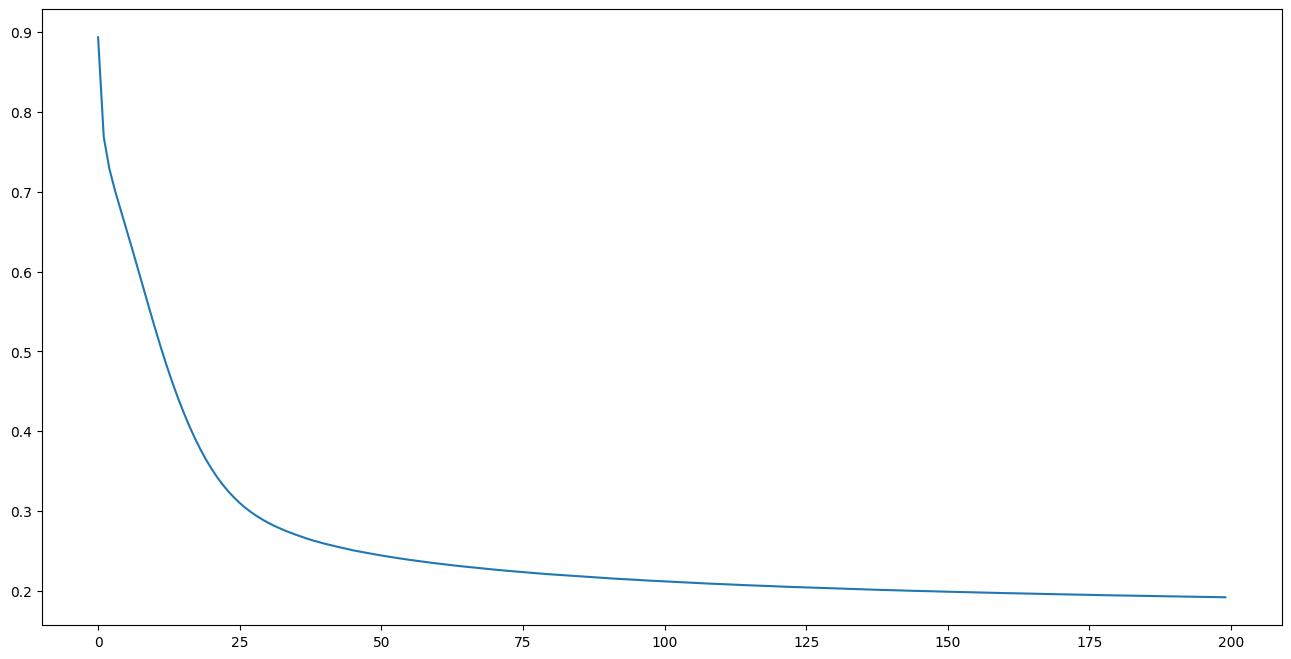

In [9]:
plt.figure(figsize=(16,8))
plt.plot(cost_list3)
plt.savefig('drop_user_place_regularizationk50epochs2000.png')

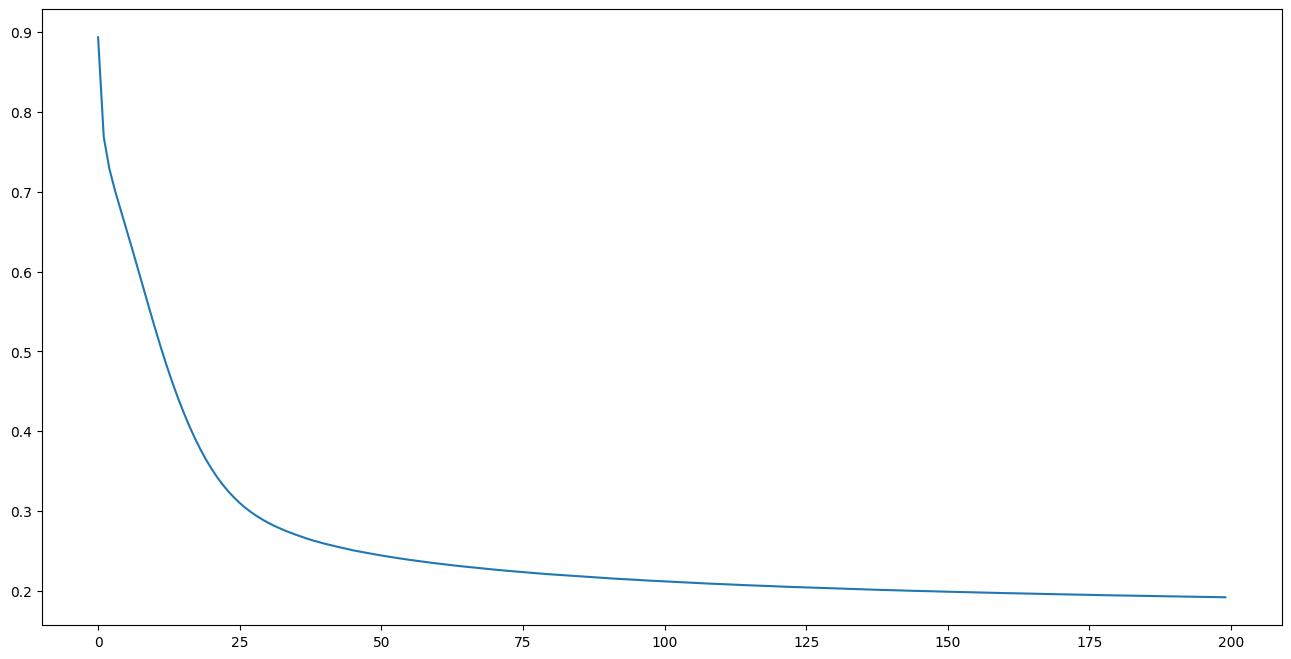

In [10]:
plt.figure(figsize=(16,8))
plt.plot(cost_list3)
plt.savefig('drop_user_product_regularizationk50epochs2000.png')

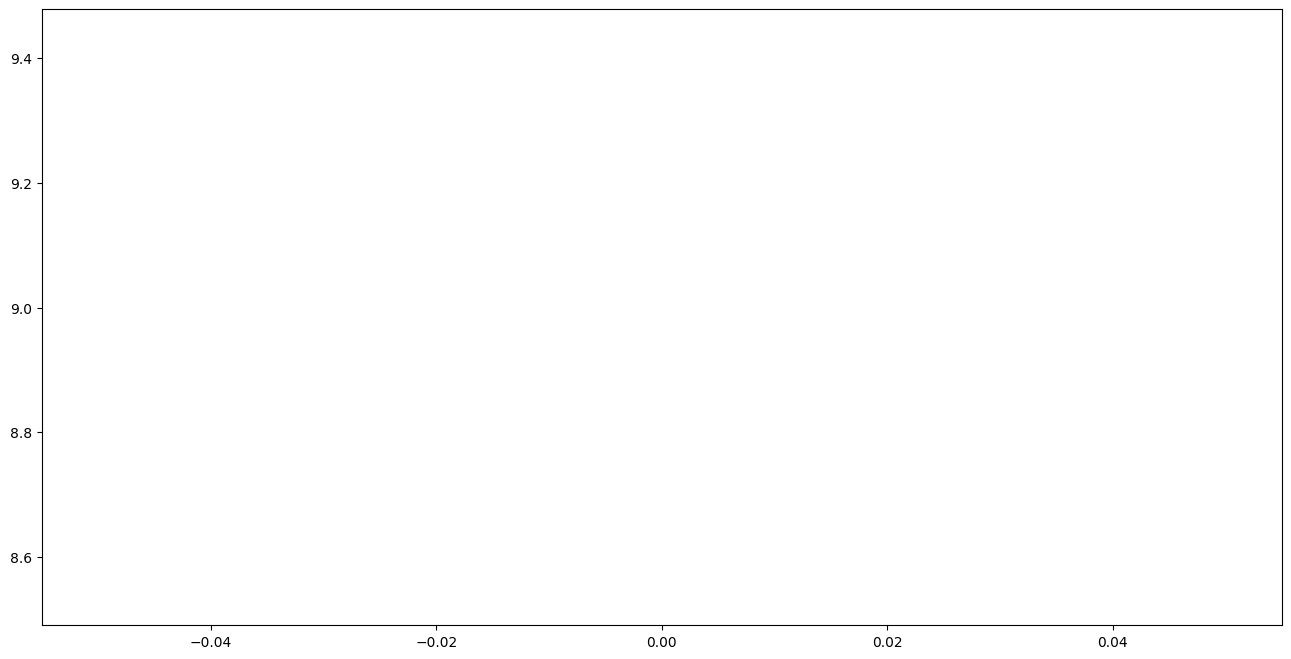

In [12]:
plt.figure(figsize=(16,8))
plt.plot(cost_list4)
#plt.savefig('drop_user_video_regularizationk50epochs2000.png')

In [8]:
df3 = pd.DataFrame(complete_matrix3).astype(dtype='float16')
df3.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_place_regularizationk50epochs2000.csv', index=False)
cost_list3 = pd.DataFrame(cost_list3).astype(dtype='float16')
cost_list3.to_csv('drop_user_place_regularizationk50epochs2000.csv', index=False)
get_user_latent3 = pd.DataFrame(user_latent3).astype(dtype='float16')
get_user_latent3.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_place_user_latent_regularizationk50epochs2000.csv', index=False)
get_item_latent3 = pd.DataFrame(item_latent3).astype(dtype='float16')
get_item_latent3.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_place_item_latent_regularizationk50epochs2000.csv', index=False)


df4 = pd.DataFrame(complete_matrix4).astype(dtype='float16')
df4.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_product_regularizationk50epochs2000.csv', index=False)
cost_list4 = pd.DataFrame(cost_list4).astype(dtype='float16')
cost_list4.to_csv('drop_user_product_regularizationk50epochs2000.csv', index=False)
get_user_latent4 = pd.DataFrame(user_latent4).astype(dtype='float16')
get_user_latent4.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_product_user_latent_regularizationk50epochs2000.csv', index=False)
get_item_latent4 = pd.DataFrame(item_latent4).astype(dtype='float16')
get_item_latent4.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_product_item_latent_regularizationk50epochs2000.csv', index=False)


df5 = pd.DataFrame(complete_matrix5).astype(dtype='float16')
df5.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_video_regularizationk50epochs2000.csv', index=False)
cost_list5 = pd.DataFrame(cost_list5).astype(dtype='float16')
cost_list5.to_csv('drop_user_video_regularizationk50epochs2000.csv', index=False)
get_user_latent5 = pd.DataFrame(user_latent5).astype(dtype='float16')
get_user_latent5.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_video_user_latent_regularizationk50epochs2000.csv', index=False)
get_item_latent5 = pd.DataFrame(item_latent5).astype(dtype='float16')
get_item_latent5.to_csv('../Data/whyout_data/sgd_result/del_data/drop_user_video_item_latent_regularizationk50epochs2000.csv', index=False)